In [7]:
from segmentator import Segmentator
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
import torch

In [3]:
segm = Segmentator(use_wandb=False, dataset = "Lesion", num_epochs = 3)
segm.set_seed(42)

Using device: cpu
Loading dataset: Lesion
Loaded 128 training images
Loaded 40 test images
Loaded 32 validation images


In [4]:
data, mask = next(iter(segm.train_loader))
mask.shape

torch.Size([6, 1, 128, 128])

In [9]:
from val_metrics import dice_overlap, IoU, accuracy, sensitivity, specificity
accuracy(mask, torch.ones_like(mask))

1.0

In [14]:
y_true = mask
y_pred = torch.ones_like(mask)

_, y_true_argmax = torch.max(y_true.float(), dim=1)
_, y_pred_argmax = torch.max(y_pred.float(), dim=1)
correct_predictions = torch.eq(y_true_argmax, y_pred_argmax).float()
y_true_argmax.unique(), y_pred_argmax.unique()
# accuracy_score = torch.mean(correct_predictions).item()

# accuracy_score

(tensor([0]), tensor([0]))

In [19]:
y_true.unique(return_counts=True), y_pred.unique()

((tensor([0., 1.]), tensor([76535, 21769])), tensor([1.]))

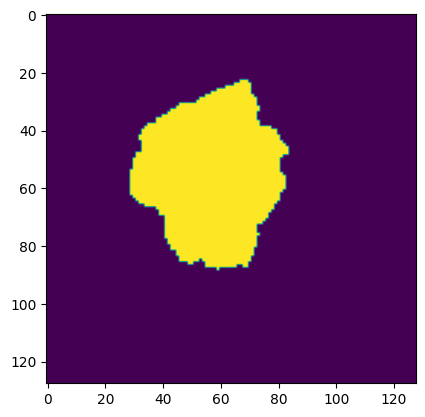

In [16]:
plt.imshow(y_true[0,0,:,:])

In [30]:
class Scorer:
    def __init__(self, y_true, y_pred, class_dims = 1):
        if class_dims > 1:
            raise NotImplementedError("Not implemented for class_dims > 1, i.e. multiclass")
        
        self.y_true = y_true
        self.y_pred_vals = y_pred
        self.y_pred = (y_pred > 0.5).int()
        
        # get confusion matrix
        self.tp = torch.sum(self.y_true * self.y_pred, dim=[1, 2, 3])
        self.fp = torch.sum((1 - self.y_true) * self.y_pred, dim=[1, 2, 3])
        self.fn = torch.sum(self.y_true * (1 - self.y_pred), dim=[1, 2, 3])
        self.tn = torch.sum((1 - self.y_true) * (1 - self.y_pred), dim=[1, 2, 3])
    
    def sensitivity(self):
        return torch.mean(self.tp / (self.tp + self.fn + 1e-6))
    
    def specificity(self):
        return torch.mean(self.tn / (self.tn + self.fp + 1e-6))
    
    def accuracy(self):
        return torch.mean((self.tp + self.tn) / (self.tp + self.tn + self.fp + self.fn + 1e-6))
    
    def IoU(self):
        intersection = torch.sum(self.y_true * self.y_pred, dim=[1, 2, 3])
        union = torch.sum(self.y_true + self.y_pred, dim=[1, 2, 3]) - intersection
        return torch.mean((intersection + 1e-6) / (union + 1e-6))
    
    def dice(self):
        iou = self.IoU()
        return 2*iou/(1+iou)
    
    def get_scores(self):
        return {
            "dice_overlap": self.dice(),
            "IoU": self.IoU(),
            "accuracy": self.accuracy(),
            "sensitivity": self.sensitivity(),
            "specificity": self.specificity(),
        }
    
        
        
        

# s = Scorer(y_true, torch.rand_like(y_true))
s = Scorer(y_true, torch.ones_like(y_true))
s.specificity()

tensor(0.)

/work3/s183920/02514-DLCI/DLCI-venv/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


(3, 128, 128)
(3, 128, 128)
(3, 128, 128)
(3, 128, 128)
(3, 128, 128)
(3, 128, 128)


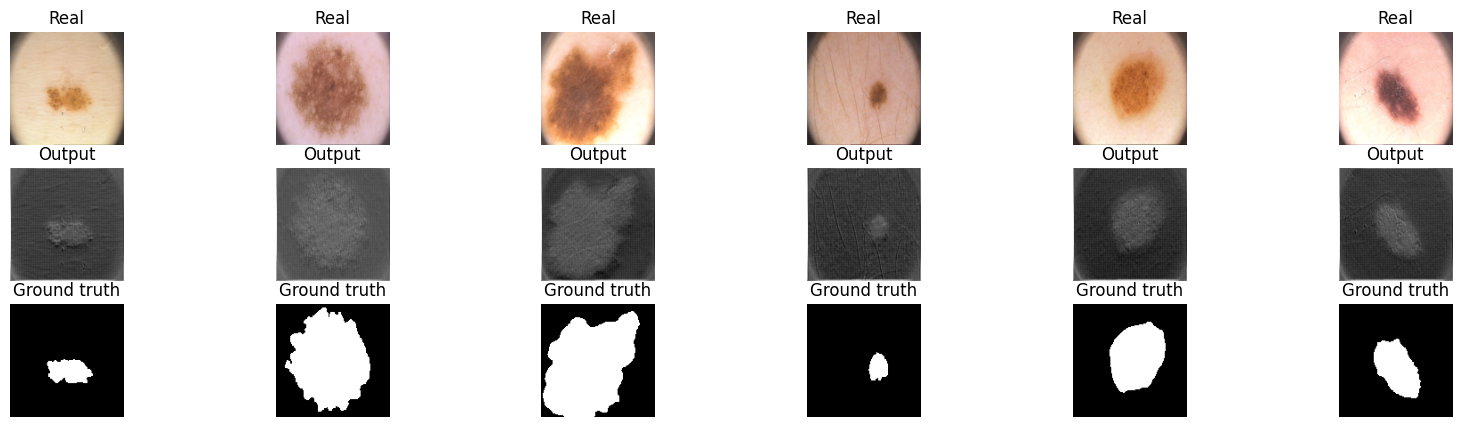

In [11]:
X_test, Y_test = next(iter(segm.val_loader))

# show intermediate results
segm.model.eval()  # testing mode
Y_hat = F.sigmoid(segm.model(X_test.to(segm.device))).detach().cpu()



fig, axes = plt.subplots(3, 6, figsize=(20, 5))
for k in range(6):
    
    # show input image
    ax = axes[0, k]
    print(X_test[k].numpy().shape)
    ax.imshow(np.rollaxis(X_test[k].numpy(), 0, 3), cmap='gray')
    ax.set_title('Real')
    ax.set_axis_off()

    # show mask prediction
    ax = axes[1, k]
    ax.imshow(Y_hat[k, 0], cmap='gray')
    ax.set_title('Output')
    ax.set_axis_off()
    
    # show ground truth mask
    ax = axes[2, k]
    ax.imshow(Y_test[k, 0], cmap='gray')
    ax.set_title('Ground truth')
    ax.set_axis_off()

Using device: cpu
Loading dataset: Lesion
Loaded 128 training images
Loaded 40 test images
Loaded 32 validation images


/work3/s183920/02514-DLCI/DLCI-venv/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


(3, 128, 128)
(3, 128, 128)
(3, 128, 128)
(3, 128, 128)
(3, 128, 128)
(3, 128, 128)


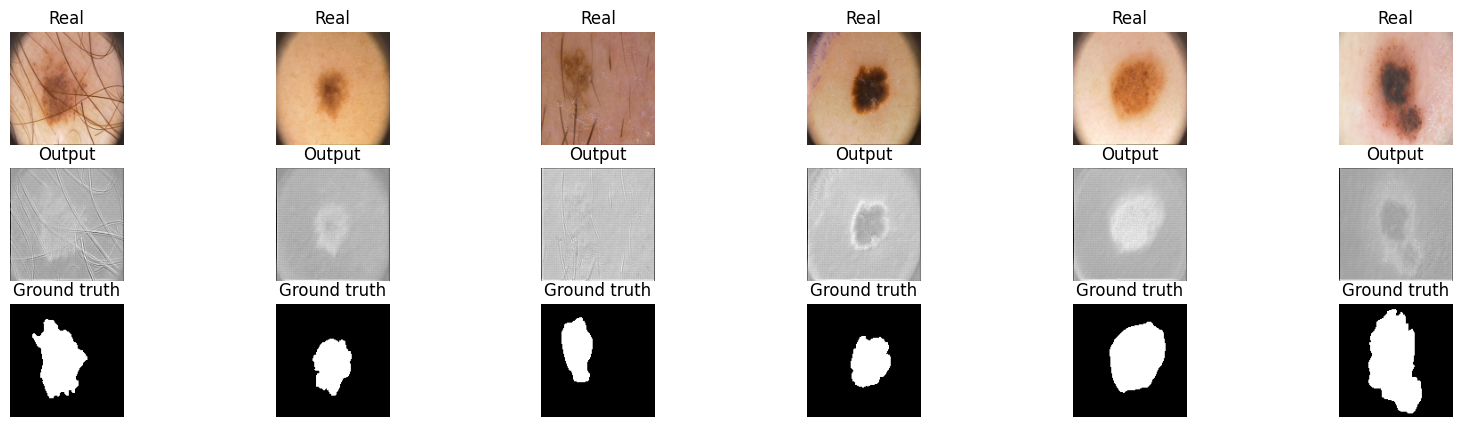

In [12]:
segm = Segmentator(use_wandb=False, dataset = "Lesion", num_epochs = 3)
segm.set_seed(42)

X_test, Y_test = next(iter(segm.val_loader))

# show intermediate results
segm.model.eval()  # testing mode
Y_hat = F.sigmoid(segm.model(X_test.to(segm.device))).detach().cpu()



fig, axes = plt.subplots(3, 6, figsize=(20, 5))
for k in range(6):
    
    # show input image
    ax = axes[0, k]
    print(X_test[k].numpy().shape)
    ax.imshow(np.rollaxis(X_test[k].numpy(), 0, 3), cmap='gray')
    ax.set_title('Real')
    ax.set_axis_off()

    # show mask prediction
    ax = axes[1, k]
    ax.imshow(Y_hat[k, 0], cmap='gray')
    ax.set_title('Output')
    ax.set_axis_off()
    
    # show ground truth mask
    ax = axes[2, k]
    ax.imshow(Y_test[k, 0], cmap='gray')
    ax.set_title('Ground truth')
    ax.set_axis_off()

In [ ]:
X_test, Y_test = next(iter(segm.val_loader))

# show intermediate results
segm.model.eval()  # testing mode
Y_hat = F.sigmoid(segm.model(X_test.to(segm.device))).detach().cpu()



fig, axes = plt.subplots(3, 6, figsize=(20, 5))
for k in range(6):
    
    # show input image
    ax = axes[0, k]
    print(X_test[k].numpy().shape)
    ax.imshow(np.rollaxis(X_test[k].numpy(), 0, 3), cmap='gray')
    ax.set_title('Real')
    ax.set_axis_off()

    # show mask prediction
    ax = axes[1, k]
    ax.imshow(Y_hat[k, 0], cmap='gray')
    ax.set_title('Output')
    ax.set_axis_off()
    
    # show ground truth mask
    ax = axes[2, k]
    ax.imshow(Y_test[k, 0], cmap='gray')
    ax.set_title('Ground truth')
    ax.set_axis_off()

In [9]:
segm.val_loader.dataset.__getitem__(0)

(tensor([[[0.1922, 0.1922, 0.2039,  ..., 0.1882, 0.2000, 0.6784],
          [0.1882, 0.1922, 0.2000,  ..., 0.1843, 0.2039, 0.6784],
          [0.1961, 0.2039, 0.2196,  ..., 0.2039, 0.2078, 0.6824],
          ...,
          [0.2314, 0.2353, 0.2275,  ..., 0.2157, 0.2314, 0.6902],
          [0.2392, 0.2431, 0.2392,  ..., 0.2235, 0.2392, 0.6941],
          [0.6980, 0.7020, 0.7020,  ..., 0.6902, 0.6980, 0.8784]],
 
         [[0.1804, 0.1804, 0.1882,  ..., 0.1843, 0.1882, 0.6745],
          [0.1843, 0.1882, 0.1922,  ..., 0.1882, 0.1922, 0.6745],
          [0.1843, 0.1843, 0.1922,  ..., 0.1843, 0.1922, 0.6745],
          ...,
          [0.2039, 0.1961, 0.1922,  ..., 0.1843, 0.1961, 0.6824],
          [0.2157, 0.2118, 0.2039,  ..., 0.1961, 0.2078, 0.6863],
          [0.6902, 0.6863, 0.6863,  ..., 0.6824, 0.6902, 0.8745]],
 
         [[0.1961, 0.2039, 0.2039,  ..., 0.1882, 0.2157, 0.6863],
          [0.1961, 0.2118, 0.2157,  ..., 0.1961, 0.2118, 0.6863],
          [0.1961, 0.2039, 0.2157,  ...,

In [33]:
print(f"{np.random.rand():.3f}")

0.183
